## Pipeline SVM: Preprocesamiento, Búsqueda de Hiperparámetros y Evaluación

En las siguientes celdas se carga el dataset limpio, se define un pipeline que incluye preprocesamiento (escalado) y un clasificador SVM, se realiza búsqueda sistemática de hiperparámetros con `GridSearchCV` y `BayesSearch`, y se evalúa el mejor modelo en un set de prueba. Se guardan resultados resumidos para extraer conclusiones.

In [2]:
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
TARGET_COL = 'Diabetes'
OUT_DIR = '../svm_results/'

df = pd.read_csv('../data/diabetes_train.csv') 
df_test = pd.read_csv('../data/diabetes_test.csv')


with open('../data/dictionary.json', 'r') as f:
    data_dict = json.load(f)

# Supongamos que la columna se llama 'Clase'
df[TARGET_COL] = df[TARGET_COL].replace(2, 1)
df_test[TARGET_COL] = df_test[TARGET_COL].replace(2, 1)

df.shape

(12500, 22)

In [4]:
numeric_columns = []
categorical_columns = []
ordinal_columns = []
for col, info in data_dict.items():
    if info['type'] == 'numerical':
        numeric_columns.append(col)
    elif info['type'] == 'categorical':
        categorical_columns.append(col)
    elif info['type'] == 'ordinal':
        ordinal_columns.append(col)


# 2. Creamos el procesador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        # ('ord', OrdinalEncoder(), ordinal_columns) 
        ('ord', StandardScaler(), ordinal_columns) # Usamos StandardScaler para variables ordinales con varias clases ya que OrdinalEncoder las deja como enteros > 1
    ]
)



In [ ]:
pipe = Pipeline([
    ('preprocesor', preprocessor),
    # ('fss', SelectKBest()), # Selección de características
    ('clf', SVC(probability=False)) # False para entrenar más rápido (cambiar para obtener probabilidades)
])

param_grid = {
    # 'fss__score_func': [chi2, mutual_info_classif],
    # 'fss__k': [4, 6, 10, 11, all],
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto', 0.1, 0.01] # Añadidos valores numéricos explícitos
}

n_combinations = len(param_grid['clf__C']) * len(param_grid['clf__kernel']) * len(param_grid['clf__gamma'])
cv_folds = 3
total_fits = n_combinations * cv_folds

# grid = GridSearchCV(
#     pipe,
#     param_grid,
#     cv=cv_folds,
#     scoring='f1_macro',
#     # n_jobs=-1
#     verbose=1
#     )

grid = BayesSearchCV(
    pipe,
    param_grid,
    cv=cv_folds,
    n_iter=10,
    scoring='f1_macro',
    # n_jobs=-1
    verbose=1
    )

In [6]:
X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

display(X_train.head())

,BMI,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartAttack,PhysActivity,Fruits,Veggies,...,HealthCare,Unaffordable_care,DiffWalk,Sex,GeneralHealth,MentalHealth,PhysicalHealth,Age,Education,Income
0,23.0,0,0,1,0,0,0,1,0,1,...,1,0,0,1,1,0,0,1,4,6
1,24.0,0,0,0,0,0,0,1,1,1,...,1,0,0,1,1,2,0,8,4,8
2,26.0,1,1,1,0,0,1,1,1,1,...,1,0,1,0,5,0,6,13,6,8
3,23.0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,1,0,0,8,6,8
4,24.0,1,1,1,1,0,0,1,1,1,...,1,1,1,0,2,1,0,13,6,4


In [7]:
grid.fit(X_train, y_train)

# Resultados
full_grid_results = pd.DataFrame(grid.cv_results_)
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_
["mean_test_score"], columns=["Accuracy"])],axis=1)

best = grid.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [7]:
# # grid_contour = grid_results.groupby(['fss__score_func', 'fss__k', 'clf__gamma','clf__kernel', 'clf__C']).mean()
# grid_contour = grid_results.groupby(['clf__gamma','clf__kernel', 'clf__C']).mean()

# display(grid_contour)

In [8]:
display(full_grid_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__gamma,param_clf__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.285050,0.481900,0.883385,0.220640,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
1,2.843905,0.063663,0.746775,0.067666,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
2,2.818422,0.328383,0.787349,0.055973,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
3,2.298123,0.109461,0.587857,0.006837,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
4,2.411489,0.218762,0.739434,0.176271,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
5,2.461171,0.245309,0.619495,0.058287,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
6,2.343983,0.125374,0.629947,0.041526,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
7,2.388649,0.417914,0.622823,0.052999,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
8,2.155717,0.207761,0.608049,0.076472,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1
9,2.421735,0.076745,0.632636,0.007063,0.1,scale,linear,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.742437,0.744558,0.737813,0.741603,0.002816,1


In [9]:
best_params = grid.best_params_
best_params

OrderedDict([('clf__C', 0.1),
             ('clf__gamma', 'scale'),
             ('clf__kernel', 'linear')])

### UTILIZAMOS FSS

Una vez que tenemos el FSS añadimos los mejores parámetros al FSS para ver si mejora. 

In [10]:
pipe2 = Pipeline([
    ('preprocesor', preprocessor),
    ('fss', SelectKBest()), # Selección de características
    ('clf', SVC(probability=True)) # False para entrenar más rápido (cambiar para obtener probabilidades)
])

param_grid2 = {
    'fss__score_func': [f_classif, mutual_info_classif],
    'fss__k': [4, 6, 10, 11],
    'clf__C': [0.1],
    'clf__kernel': ['linear'],
    'clf__gamma': ['scale'] # Añadidos valores numéricos explícitos
}

n_combinations = len(param_grid2['fss__score_func']) * len(param_grid2['fss__k'])
cv_folds = 3
total_fits = n_combinations * cv_folds

grid2 = GridSearchCV(
    pipe2,
    param_grid2,
    cv=cv_folds,
    scoring='f1_macro',
    # n_jobs=-1
    verbose=1
    )


In [30]:
grid2.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,Pipeline(step...ility=True))])
,param_grid,"{'clf__C': [0.1], 'clf__gamma': ['scale'], 'clf__kernel': ['linear'], 'fss__k': [4, 6, ...], ...}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [12]:
grid_results_FSS= pd.DataFrame(grid2.cv_results_)
grid_results = pd.DataFrame(grid.cv_results_)

#### RESULTADOS FINALES

In [34]:
# Evaluación en test set
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
roc_curve_1 = roc_curve(y_test, y_pred)
roc_auc = auc(roc_curve_1[0], roc_curve_1[1])

y_pred = grid2.predict(X_test)
acc_2 = accuracy_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred, pos_label=1)
recall_2 = recall_score(y_test, y_pred, pos_label=1)
precision_2 = precision_score(y_test, y_pred, pos_label=1)
roc_curve_2 = roc_curve(y_test, y_pred)
roc_auc_2 = auc(roc_curve_2[0], roc_curve_2[1])

In [36]:
import pandas as pd
from sklearn.base import clone

# --- CONFIGURACIÓN ---
POS_LABEL = 1  # Cambia a 1 si transformaste tus etiquetas a 0/1
tabla_resultados = []

# ==========================================
# 1. PROCESAR MEJOR MODELO DEL GRID 1
# ==========================================

# Métricas
res_g1 = {
    'Modelo': 'Grid 1 (Best)',
    'Params': str(grid.best_params_),
    'Accuracy': acc,
    'F1': f1,
    'Recall': recall,
    'Precision': precision,
    'AUC': auc
}
tabla_resultados.append(res_g1)

# ==========================================
# 2. PROCESAR TODOS LOS MODELOS DEL GRID 2
# ==========================================
print(f"Evaluando {len(grid2.cv_results_['params'])} modelos del Grid 2 en el Test Set...")

# Iteramos sobre cada combinación de parámetros probada en Grid 2
for params in grid2.cv_results_['params']:
    
    # 1. Clonamos el pipeline original limpio
    model_temp = clone(grid2.estimator)
    
    # 2. Le asignamos los parámetros de esta iteración
    model_temp.set_params(**params)
    
    # 3. Entrenamos (necesario para evaluar en Test)
    model_temp.fit(X_train, y_train)
    
    # 4. Predecimos
    preds = model_temp.predict(X_test)
    probs = model_temp.predict_proba(X_test)[:, 1] # Ahora sí funciona porque probability=True
    
    # 5. Calculamos métricas
    fpr, tpr, _ = roc_curve(y_test, probs, pos_label=POS_LABEL)
    
    res = {
        'Modelo': 'Grid 2',
        'Params': str(params),
        'Accuracy': accuracy_score(y_test, preds),
        'F1': f1_score(y_test, preds, pos_label=POS_LABEL),
        'Recall': recall_score(y_test, preds, pos_label=POS_LABEL),
        'Precision': precision_score(y_test, preds, pos_label=POS_LABEL),
        'AUC': auc(fpr, tpr)
    }
    tabla_resultados.append(res)

# ==========================================
# 3. CREAR TABLA FINAL Y ORDENAR
# ==========================================
df_final = pd.DataFrame(tabla_resultados)

# Separamos Grid 1 del resto para ordenar solo Grid 2
df_g1 = df_final[df_final['Modelo'] == 'Grid 1 (Best)']
df_g2 = df_final[df_final['Modelo'] == 'Grid 2'].sort_values(by='F1', ascending=False)

# Concatenamos: Primero el G1, luego el ranking de G2
df_display = pd.concat([df_g1, df_g2], ignore_index=True)

# Mostramos
display(df_display)

Evaluando 8 modelos del Grid 2 en el Test Set...


,Modelo,Params,Accuracy,F1,Recall,Precision,AUC
0,Grid 1 (Best),"OrderedDict({'clf__C': 0.1, 'clf__gamma': 0.01...",0.713734,0.462910,0.782864,0.328608,<function auc at 0x000001C191AE2480>
1,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.704904,0.453577,0.777236,0.320227,0.810178
2,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.704904,0.453577,0.777236,0.320227,0.810183
3,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.703485,0.452707,0.778236,0.319192,0.808724
4,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.703485,0.452707,0.778236,0.319192,0.808725
5,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.685194,0.437606,0.777236,0.304533,0.798895
6,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.646444,0.397083,0.738837,0.271499,0.774039
7,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.646444,0.397083,0.738837,0.271499,0.778267
8,Grid 2,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.646444,0.397083,0.738837,0.271499,0.781945


In [21]:
print("\n" + "=" * 70)
print("MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)")
print("=" * 70)
print(f"\n✓ Accuracy: {acc:.4f}")
print(f"✓ F1-Score (macro): {f1:.4f}")
print(f"\nReporte detallado por clase:")
print(classification_report(y_test, y_pred))


# Guardar resumen de métricas
summary = {
    'best_params': grid.best_params_,
    'cv_best_score_f1_macro': float(grid.best_score_),
    'test_accuracy': float(acc),
    'test_f1_macro': float(f1)
    }

with open(OUT_DIR + 'summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)


MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)

✓ Accuracy: 0.7137
✓ F1-Score (macro): 0.4629

Reporte detallado por clase:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     42741
           1       0.32      0.78      0.45      7995

    accuracy                           0.71     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.85      0.71      0.74     50736



### INTERPRETACIÓN

C:\Users\SergioBeamonteGonzal\AppData\Local\Temp\ipykernel_17288\325179621.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


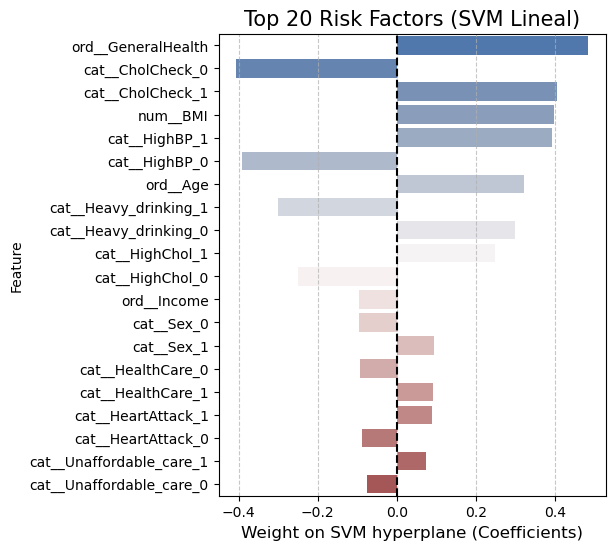

In [16]:
# 1. Recuperamos el mejor modelo del GridSearch (Grid 1)
best_model = grid.best_estimator_

# 2. Separamos el preprocesador y el clasificador
preprocessor = best_model.named_steps['preprocesor']
classifier = best_model.named_steps['clf']

# 3. Obtenemos los nombres de las características transformadas
# Esto es vital porque el OneHotEncoder creó nuevas columnas (ej: GenHealth_1, GenHealth_2...)
feature_names = preprocessor.get_feature_names_out()

# 4. Obtenemos los coeficientes (pesos) del SVM lineal
# .flatten() convierte el array 2D en 1D
coefficients = classifier.coef_.flatten()

# 5. Creamos un DataFrame para ordenar y visualizar
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coeff': np.abs(coefficients) # Para ordenar por impacto absoluto
})

# Ordenamos por importancia (valor absoluto)
df_importance = df_importance.sort_values(by='Abs_Coeff', ascending=False)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(5, 6))
# Usamos un mapa de color divergente: Rojo (positivo/riesgo) vs Azul (negativo/protector)
sns.barplot(
    data=df_importance.head(20), # Top 20 variables más importantes
    x='Coefficient', 
    y='Feature', 
    palette='vlag' 
)
plt.title('Top 20 Risk Factors (SVM Lineal)', fontsize=15)
plt.xlabel('Weight on SVM hyperplane (Coefficients)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--') # Línea central
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [14]:
print(df_importance)

                     Feature  Coefficient  Abs_Coeff
29        ord__GeneralHealth     0.485388   0.485388
5           cat__CholCheck_0    -0.406485   0.406485
6           cat__CholCheck_1     0.406485   0.406485
0                   num__BMI     0.397871   0.397871
2              cat__HighBP_1     0.392287   0.392287
1              cat__HighBP_0    -0.392287   0.392287
32                  ord__Age     0.323294   0.323294
20     cat__Heavy_drinking_1    -0.300000   0.300000
19     cat__Heavy_drinking_0     0.300000   0.300000
4            cat__HighChol_1     0.249512   0.249512
3            cat__HighChol_0    -0.249512   0.249512
34               ord__Income    -0.096667   0.096667
27                cat__Sex_0    -0.095671   0.095671
28                cat__Sex_1     0.095671   0.095671
21         cat__HealthCare_0    -0.092039   0.092039
22         cat__HealthCare_1     0.092039   0.092039
12        cat__HeartAttack_1     0.088743   0.088743
11        cat__HeartAttack_0    -0.088743   0.